# DaskDataSet Example

Creates a ~2.5 GB raw dataset, loads it as a chunked Dask array and then runs sig and nav sum UDFs on it.

The only new code in LiberTEM is the Dask array wrapper, it wasn't necessary to modify the UDFRunner or other endpoints.

In [1]:
import os
import math
import itertools
from time import perf_counter
from contextlib import contextmanager
import pathlib
import numpy as np
import distributed
import dask
import dask.array as da
import matplotlib.pyplot as plt

In [2]:
import libertem.api as lt
from libertem.executor.dask import DaskJobExecutor
from dask_dataset import DaskDataSet
from libertem.udf.sum import SumUDF
from libertem.udf.sumsigudf import SumSigUDF

### Util functions

In [3]:
def make_raw_ds(fpath, dtype, sig_shape, nav_shape, div=0):
    assert sig_shape[0] == sig_shape[1]
    dim = sig_shape[0]
    ramp = np.linspace(0, 1., num=dim, endpoint=True, dtype=dtype)
    base_array = ramp[:, np.newaxis] * ramp[np.newaxis, :]
    if div > 0:
        stripe = dim // div
        linear_mask = np.zeros((dim,), dtype=bool)
        for s in range(stripe//2, dim, 2*stripe):
            linear_mask[s:s+stripe] = True
        base_array[linear_mask,:] = 0
        base_array[:, linear_mask] = 0
    with pathlib.Path(fpath).open('wb') as fp:
        for idx in range(np.prod(nav_shape)):
            fp.write((base_array * idx).data)  
            
@contextmanager
def timer(msg=None):
    start = perf_counter()
    yield
    if msg is None:   
        print(f'{perf_counter()-start:.3f} s')
    else:
        print(f'{msg} - {perf_counter()-start:.3f} s')


def take_n(iterable, n):
    """
    Split a interable into chunks of length n with the final element
    being the remainder len < n if n does not divide evenly
    """
    len_iter = len(iterable)
    return [iterable[i:min(i+n, len_iter)] for i in range(0, len_iter, n)]


def reshape_list(to_reshape, new_shape):
    """
    Recursively reshape a list into new_shape following C-ordering
    Unlike numpy.reshape this will happily create a ragged array when 
    the dimensions in new_shape do not divide perfectly into to_reshape!
    """
    left = new_shape[:-1]
    n = new_shape[-1]
    reshaped = take_n(to_reshape, n)
    if len(left) == 0:
        return reshaped[0]
    else:
        return reshape_list(reshaped, left)           

### da.array creation routines

In [4]:
def mmap_load_chunk(filename, shape, dtype, offset, sl):
    data = np.memmap(filename, mode='r', shape=shape, dtype=dtype, offset=offset)
    return data[sl]


def load_chunk(filename, shape, dtype, offset, sl):
    """
    An implementation of loading a raw file without memmapping
    Tested this for Windows use but found no real improvement on this data size
    Offset is not supported with this read function except for an integer number of items
    Currently only supports slices in the first dimension!
    """
    # tested this for Windows use but found no real improvement on this data
    # offset is not supported with this read function except for an integer number of items
    dtype_bytes = np.dtype(dtype).itemsize
    macroframe_itemsize = math.prod(shape[1:])
    start_item = sl.start *  macroframe_itemsize
    end_item = sl.stop * macroframe_itemsize
    np_shape = (sl.stop - sl.start,) + shape[1:]
    with filename.open('rb') as fp:
        return np.fromfile(fp, offset=start_item * dtype_bytes, dtype=dtype, count=end_item - start_item).reshape(np_shape)


def blocksize_to_dim_slices(blocksize, dim):
    """
    Generate the slices along a dimension of length dim
    to split dim into chunks of length blocksize, with the final chunk
    being the remainder if dim % blocksize != 0
    
    A blocksize of -1 is converted to a None slice
    """
    slices = []
    if blocksize == -1:
        slices.append(slice(None))
    else:
        for index in range(0, dim, blocksize):
            chunk_size = min(blocksize, dim - index)
            slices.append(slice(index, index + chunk_size))
    return slices 


def slices_to_chunk_shape(slices, full_shape):
    """
    Generate the shape tuple of the array resulting from applying
    the sequence of slices to an array with shape full_shape
    """
    chunk_shape = []
    for s, dim in zip(slices, full_shape):
        if s.start is not None and s.stop is not None:
            chunk_shape.append(s.stop - s.start)
        elif s.start is None and s.stop is None:
            chunk_shape.append(dim)
        else:
            raise NotImplementedError(f'Open-ended slices are currently unhandled {s}')
    return tuple(chunk_shape)    


def get_block_slices(blocksizes, shape):
    """
    Converts blocksizes into a list of list of slices along each dimension in shape
    An integer blocksizes is treated as a blocksize for the 0th dimension only
    A blocksize of -1 is treated as slice(None) for that dimension
    """
    if isinstance(blocksizes, int):
        # assume chunking only in first dimension
        blocksizes = (blocksizes,) + ((-1,) * len(shape[1:]))
    assert len(blocksizes) == len(shape), 'Must supply a blocksize for every dimension, (-1 == no chunking), or int'
    return [blocksize_to_dim_slices(bsize, dim) for bsize, dim in zip(blocksizes, shape)]


def create_dask_array(filename, shape, dtype, offset=0, blocksizes=8):
    """
    Create a dask array from a raw file using memmapping
    
    Chunking is defined by blocksizes, see prior docstrings for info
    """
    load = dask.delayed(mmap_load_chunk, name='mmap_load_chunk', pure=True, traverse=False)
    
    slices_per_dim = get_block_slices(blocksizes, shape)
    blocks = []
    # rightmost advances fastest with itertools.product
    for chunk_slices in itertools.product(*slices_per_dim):
        chunk_shape = slices_to_chunk_shape(chunk_slices, shape)
        chunk = dask.array.from_delayed(
            load(
                filename,
                shape=shape,
                dtype=dtype,
                offset=offset,
                sl=chunk_slices
            ),
            shape=chunk_shape,
            dtype=dtype
        )
        blocks.append(chunk)
    nblocks_per_dim = tuple([len(ss) for ss in slices_per_dim])
    blocks = reshape_list(blocks, nblocks_per_dim)
    return da.block(blocks)

### Setup Dask/Distributed

In [5]:
with timer('Create Dask Scheduler'):
    client = distributed.Client()

Create Dask Scheduler - 1.556 s


### Parameters and make dataset

In [6]:
path = pathlib.Path('./ds.raw').absolute()
nav_shape = (70,128)
sig_shape = (256,256)
shape = nav_shape + sig_shape
dtype = np.float32
if not path.is_file():
    make_raw_ds(path, np.float32, sig_shape, nav_shape, div=8)

In [23]:
blocksizes = (8, -1, -1, -1) # number of elements per-block per-dimension

In [8]:
d_arr = create_dask_array(
    filename=path,
    shape=shape,
    dtype=dtype,
    blocksizes=blocksizes
)
d_arr

dask.array<concatenate, shape=(70, 128, 256, 256), dtype=float32, chunksize=(8, 128, 256, 256), chunktype=numpy.ndarray>

### Load LiberTEM context and the DaskDataSet

In [9]:
executor = DaskJobExecutor(client)
ctx = lt.Context(executor=executor)

In [10]:
ds = DaskDataSet(d_arr, sig_dims=len(sig_shape), preserve_dimensions=False)
ds.initialize(executor)
ds.array

dask.array<concatenate, shape=(70, 128, 256, 256), dtype=float32, chunksize=(8, 128, 256, 256), chunktype=numpy.ndarray>

#### Try to warm up the filecache

In [11]:
with path.open('rb') as fp:
    array = np.fromfile(fp, dtype=dtype).reshape(shape)

#### Run UDFs

In [12]:
sum_udf = SumUDF()
sigsum_udf = SumSigUDF()

In [13]:
with timer('Run UDFs'):
    res = ctx.run_udf(ds, [sum_udf, sigsum_udf])

Run UDFs - 3.940 s


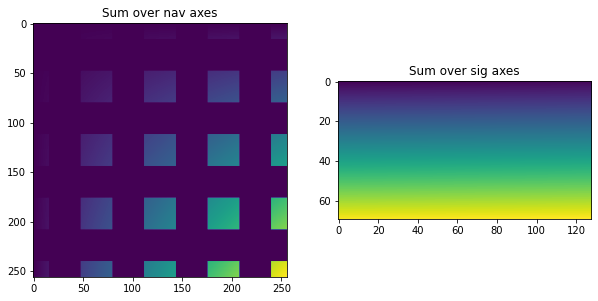

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(res[0]['intensity'].data);
axs[0].set_title('Sum over nav axes');
axs[1].imshow(res[1]['intensity'].data);
axs[1].set_title('Sum over sig axes');

### Numpy-only, whole file read

In [15]:
with timer('Numpy single read'):
    with path.open('rb') as fp:
        array = np.fromfile(fp, dtype=dtype).reshape(shape)
    xx = array.sum(axis=(0, 1))
    yy = array.sum(axis=(2, 3))

Numpy single read - 2.018 s


### Numpy-only, partitioned reads without chunk optimisation

In [16]:
with timer('Numpy partitioned read'):
    slices_per_dim = get_block_slices(blocksizes, shape)
    
    for chunk_slices in itertools.product(*slices_per_dim):
        array = mmap_load_chunk(
                path,
                shape=shape,
                dtype=dtype,
                offset=0,
                sl=chunk_slices
            )
        xx = array.sum(axis=(0, 1))
        yy = array.sum(axis=(2, 3))

Numpy partitioned read - 0.685 s


### Test various array chunkings

In [17]:
def test_blocksizes(blocksizes):
    d_arr = create_dask_array(
        filename=path,
        shape=shape,
        dtype=dtype,
        blocksizes=blocksizes
    )
    ds = DaskDataSet(d_arr, sig_dims=len(sig_shape), preserve_dimensions=False)
    original_n_blocks = [len(c) for c in d_arr.chunks]
    ds.initialize(executor)
    new_n_blocks = [len(c) for c in ds.array.chunks]
    if original_n_blocks != new_n_blocks:
        print(f'N Blocks adapted from {original_n_blocks} to {new_n_blocks}')
    with timer('Run UDFs'):
        res = ctx.run_udf(ds, [sum_udf, sigsum_udf])

In [18]:
blocksizes = (8, -1, -1, -1) # easy, zeroth dimension partitioning
test_blocksizes(blocksizes)

Run UDFs - 0.869 s


In [19]:
blocksizes = (4, 32, -1, -1) # moderate, blocks on all nav dimensions
test_blocksizes(blocksizes)

N Blocks adapted from [18, 4, 1, 1] to [17, 1, 1, 1]


/home/mat/Workspace/libertem_dev/dask_dataset/prototypes/dask_run/dask_dataset.py:213: DaskRechunkWarning: Merging nav dimension chunks according to scheme {1: -1} as we cannot maintain continuity of frame indexing in the flattened navigation dimension. Original n_blocks: [18, 4, 1, 1]. New n_blocks: [18, 1, 1, 1].
  warnings.warn(('Merging nav dimension chunks according to scheme '
/home/mat/Workspace/libertem_dev/dask_dataset/prototypes/dask_run/dask_dataset.py:227: DaskRechunkWarning: Applying re-chunking to increase minimum partition size. n_blocks: [18, 1, 1, 1] => [17, 1, 1, 1]. Min chunk size 67.1 => 134.2 MiB , Max chunk size 134.2 => 201.3 MiB.
  warnings.warn(('Applying re-chunking to increase minimum partition size. '


Run UDFs - 1.579 s


In [20]:
blocksizes = (1, 64, 128, 128) # hard, many partitions on zeroth nav, partitioned sig
test_blocksizes(blocksizes)

/home/mat/Workspace/libertem_dev/dask_dataset/prototypes/dask_run/dask_dataset.py:172: DaskRechunkWarning: Merging sig dim chunks as LiberTEM does not support paritioning along the sig axes. Original n_blocks: [70, 2, 2, 2]. New n_blocks: [70, 2, 1, 1].
  warnings.warn(('Merging sig dim chunks as LiberTEM does not '
/home/mat/Workspace/libertem_dev/dask_dataset/prototypes/dask_run/dask_dataset.py:227: DaskRechunkWarning: Applying re-chunking to increase minimum partition size. n_blocks: [70, 2, 1, 1] => [17, 1, 1, 1]. Min chunk size 16.8 => 134.2 MiB , Max chunk size 16.8 => 201.3 MiB.
  warnings.warn(('Applying re-chunking to increase minimum partition size. '


N Blocks adapted from [70, 2, 2, 2] to [17, 1, 1, 1]
Run UDFs - 3.427 s


In [21]:
blocksizes = (1, 1, 256, 256) # equivalent to one file per frame
test_blocksizes(blocksizes)

/home/mat/Workspace/libertem_dev/dask_dataset/prototypes/dask_run/dask_dataset.py:187: DaskRechunkWarning: Re-ordered nav_dimensions to improve partitioning, create the dataset with preserve_dimensions=True to suppress this behaviour. Original shape: (70, 128, 256, 256) with n_blocks: [70, 128, 1, 1]. New shape: (128, 70, 256, 256) with n_blocks: [128, 70, 1, 1].
  warnings.warn(('Re-ordered nav_dimensions to improve partitioning, '
/home/mat/Workspace/libertem_dev/dask_dataset/prototypes/dask_run/dask_dataset.py:227: DaskRechunkWarning: Applying re-chunking to increase minimum partition size. n_blocks: [128, 70, 1, 1] => [16, 1, 1, 1]. Min chunk size 0.3 => 146.8 MiB , Max chunk size 0.3 => 146.8 MiB.
  warnings.warn(('Applying re-chunking to increase minimum partition size. '


N Blocks adapted from [70, 128, 1, 1] to [16, 1, 1, 1]


/home/mat/.pyenv/versions/3.9.6/envs/dask_dataset/lib/python3.9/site-packages/distributed/worker.py:3877: UserWarning: Large object of size 4.17 MiB detected in task graph: 
  (<TaskProxy: <UDFTask [<libertem.udf.sum.SumUDF ob ... a0>]> (id=0)>,)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


Run UDFs - 16.701 s


In [22]:
blocksizes = (70, 128, 256, 256) # bizarre, no chunking at all, can kill workers due to memory
try:
    test_blocksizes(blocksizes)
except distributed.scheduler.KilledWorker:
    print('Task stopped, out of memory?')

/home/mat/Workspace/libertem_dev/dask_dataset/prototypes/dask_run/dask_dataset.py:159: DaskRechunkWarning: Dask array is not chunked in navigation dimensions, cannot split into nav-partitions without loading the whole dataset on each worker. Array shape: (70, 128, 256, 256). Chunking: ((70,), (128,), (256,), (256,)). Array size 2348.81024 MiB.
  warnings.warn(('Dask array is not chunked in navigation dimensions, '
/home/mat/Workspace/libertem_dev/dask_dataset/prototypes/dask_run/dask_dataset.py:187: DaskRechunkWarning: Re-ordered nav_dimensions to improve partitioning, create the dataset with preserve_dimensions=True to suppress this behaviour. Original shape: (70, 128, 256, 256) with n_blocks: [1, 1, 1, 1]. New shape: (128, 70, 256, 256) with n_blocks: [1, 1, 1, 1].
  warnings.warn(('Re-ordered nav_dimensions to improve partitioning, '
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING

Task stopped, out of memory?


distributed.nanny - WARNING - Restarting worker
